# 简单的 1010 模式

PyTorch 生成对抗式网络编程, 2020

In [8]:
# import libraries

import torch
import torch.nn as nn

import pandas
import matplotlib.pyplot as plt
import random
import numpy

## 数据函数

In [9]:
# 生成实数的函数

def generate_real():
    real_data = torch.FloatTensor(
        [random.uniform(0.8, 1.0),
         random.uniform(0.0, 0.2),
         random.uniform(0.8, 1.0),
         random.uniform(0.0, 0.2)])
    return real_data

generate_real()    

tensor([0.9107, 0.0785, 0.8718, 0.1571])

In [10]:
# 生成均匀分布随机数的函数

def generate_random(size):
    random_data = torch.rand(size)
    return random_data

generate_random(4)

tensor([0.7091, 0.5417, 0.2421, 0.1233])

## 判别网络

In [11]:
# 定义判别器类

class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(4, 3),
            nn.Sigmoid(),
            nn.Linear(3, 1),
            nn.Sigmoid()
        )
        
        # create loss function
        self.loss_function = nn.MSELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

## 测试判别器

In [12]:
# 训练判别器从噪声中分辨真实的数据

D = Discriminator()

for i in range(10000):
    # 真实数据
    D.train(generate_real(), torch.FloatTensor([1.0]))
    # 伪装数据
    D.train(generate_random(4), torch.FloatTensor([0.0]))
    pass

counter =  10000
counter =  20000


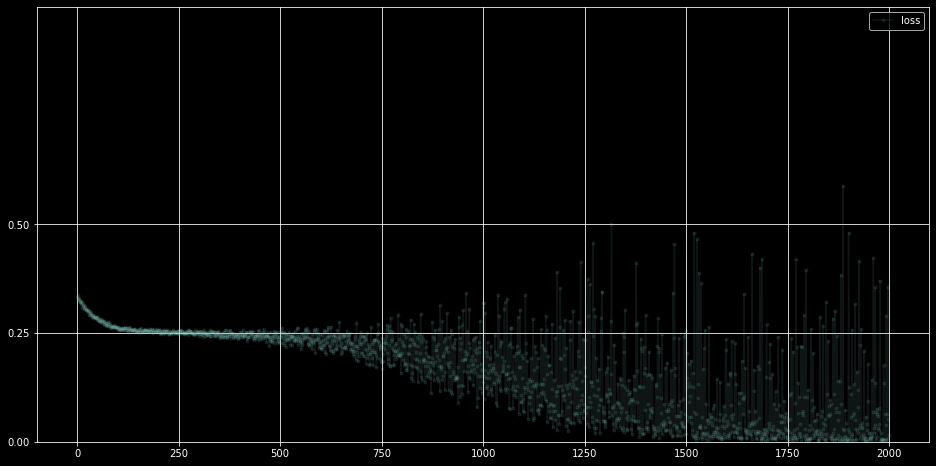

In [13]:
# 绘制判别器的进度

D.plot_progress()

In [14]:
# 手动运行判别器，检查其是否能够从噪声中分辨真实数据

print( D.forward( generate_real() ).item() )
print( D.forward( generate_random(4) ).item() )

0.7852511405944824
0.07306845486164093


## 生成器网络

In [15]:
# 定义生成器类

class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(1, 3),
            nn.Sigmoid(),
            nn.Linear(3, 4),
            nn.Sigmoid()
        )

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        # simply run model
        return self.model(inputs)
    
    
    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

## 测试生成器的输出

In [16]:
# 检测生成器的输出的类型与形状是否正确

G = Generator()

G.forward(torch.FloatTensor([0.5]))

tensor([0.5363, 0.6271, 0.5843, 0.4316], grad_fn=<SigmoidBackward>)

## 训练 GAN

In [17]:
%%time 

# 创建 生成器 与 判别器

D = Discriminator()
G = Generator()

image_list = []

# 训练 生成器 与 判别器

for i in range(10000):
    
    # 基于“真实”的数据训练判别器
    D.train(generate_real(), torch.FloatTensor([1.0]))
    
    # 基于“伪装”的数据训练判别器
    # 使用 detach() 保证生成器中的梯度不被计算
    D.train(G.forward(torch.FloatTensor([0.5])).detach(), torch.FloatTensor([0.0]))
    
    # 训练 生成器
    G.train(D, torch.FloatTensor([0.5]), torch.FloatTensor([1.0]))
    
    # 每隔 1000 次，计算一个图像
    if (i % 1000 == 0):
      image_list.append( G.forward(torch.FloatTensor([0.5])).detach().numpy() )

    pass

counter =  10000
counter =  20000
Wall time: 10.8 s


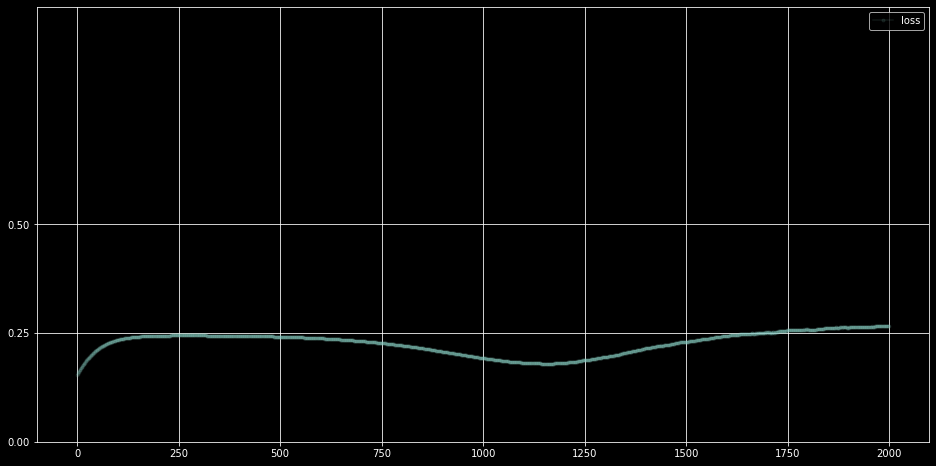

In [18]:
# 绘制判别器的误差曲线

D.plot_progress()

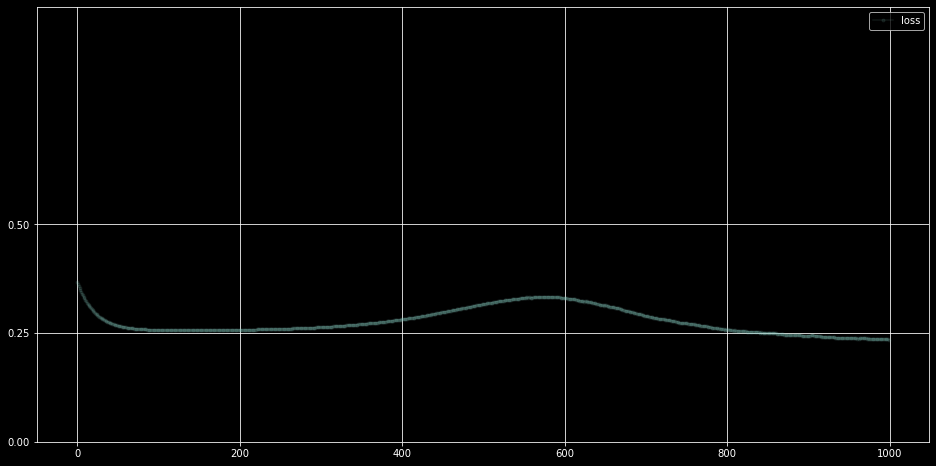

In [19]:
# 绘制生成器的误差曲线

G.plot_progress()

## 手工执行生成器（看效果）

In [20]:
G.forward(torch.FloatTensor([0.5]))

tensor([0.9138, 0.0514, 0.9090, 0.0570], grad_fn=<SigmoidBackward>)

## 训练阶段的可视化模式

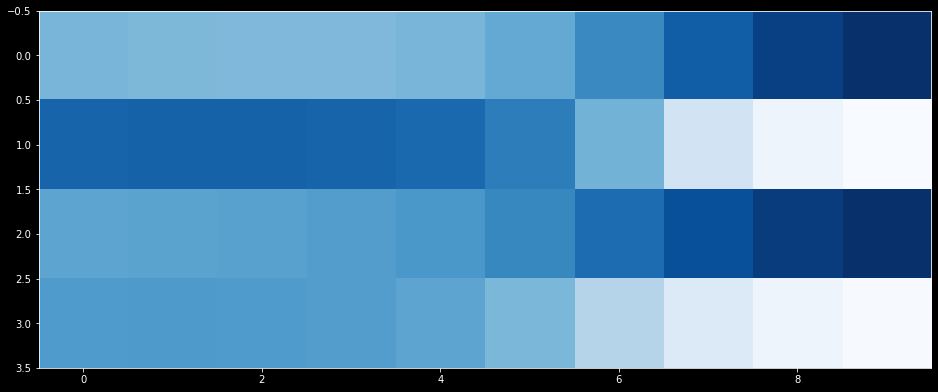

In [21]:
# 将训练阶段收集的图片可视化

plt.figure(figsize = (16,8))

plt.imshow(numpy.array(image_list).T, interpolation='none', cmap='Blues')

In [28]:
image_list[0].shape

(4,)